# 🏋️‍♂️ Personalized Multi-Agent RAG with Heart Rate Analysis using Azure AI Foundry 🥑❤️

Welcome to this advanced workshop where we'll build a personalized multi-agent Retrieval-Augmented Generation (RAG) pipeline using AutoGen 0.4.7 with Azure AI Foundry. Our team of agents will collaborate to provide fitness and health recommendations based on heart rate data analysis!

## 0. Install Required Packages

Let's first install all the required packages for this notebook. This may take a few minutes.

In [2]:
# Install required packages
import sys
import subprocess
import importlib.util

# Define required packages
packages = [
    "autogen==0.4.7",  # This should install autogen_* packages
    "autogen-agentchat==0.4.7",
    "autogen-core==0.4.7",
    "autogen-ext==0.4.7",
    "pandas",
    "numpy",
    "matplotlib",
    "azure-core",
    "python-dotenv"  # For managing environment variables
]

def check_package(package_name):
    """Check if package is installed"""
    package_name = package_name.split('==')[0]  # Remove version specifier if present
    return importlib.util.find_spec(package_name) is not None

# Install any missing packages
missing_packages = [pkg for pkg in packages if not check_package(pkg.split('==')[0])]
if missing_packages:
    print(f"Installing missing packages: {', '.join(missing_packages)}")
    for package in missing_packages:
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            print(f"✅ Successfully installed {package}")
        except subprocess.CalledProcessError as e:
            print(f"❌ Failed to install {package}: {e}")
else:
    print("All required packages are already installed.")

# Alternative method using pip directly (uncomment if needed)
# !pip install autogen==0.4.7 autogen-agentchat==0.4.7 autogen-core==0.4.7 autogen-ext==0.4.7 pandas numpy matplotlib azure-core python-dotenv

print("\n✅ Package installation complete!")

Installing missing packages: autogen==0.4.7, autogen-agentchat==0.4.7, autogen-core==0.4.7, autogen-ext==0.4.7, azure-core, python-dotenv


ERROR: Could not find a version that satisfies the requirement autogen==0.4.7 (from versions: 0.0.4, 0.0.5, 0.0.6, 0.0.7, 0.0.8, 0.0.9, 0.0.10, 0.0.11, 0.0.12, 0.0.13, 0.0.14, 0.0.15, 0.0.16, 0.0.17, 0.0.18, 0.0.19, 0.1.0, 0.1.1, 0.3.0b1, 0.3.0b4, 0.3.0, 0.3.1, 0.3.2b1, 0.3.2b2, 0.3.2, 0.4b1, 0.4, 0.4.1, 0.4.2b1, 0.5.0b2, 0.5.0, 0.5.1, 0.5.2b1, 0.5.2, 0.5.3b1, 0.5.3, 0.6.0b1, 0.6.0b2, 0.6.0, 0.6.1, 0.7.0b3, 0.7.0, 0.7.1, 0.7.2b1, 0.7.2, 0.7.3, 0.7.4b1, 0.7.4b2, 0.7.4, 0.7.5, 0.7.6b1, 0.7.6, 0.8.0b1, 0.8.0, 0.8.1, 0.8.2rc0, 0.8.2, 0.8.3, 0.8.4, 0.8.5a0, 0.8.5a1, 0.8.5, 0.8.6a2, 0.8.6b0, 0.8.6, 0.8.7, 0.8.8a0, 0.8.8a1)
ERROR: No matching distribution found for autogen==0.4.7


❌ Failed to install autogen==0.4.7: Command '['/Users/chibuk/opt/miniconda3/bin/python', '-m', 'pip', 'install', 'autogen==0.4.7']' returned non-zero exit status 1.


ERROR: Could not find a version that satisfies the requirement autogen-agentchat==0.4.7 (from versions: 0.0.2, 0.2.36, 0.2.37, 0.2.38, 0.2.39, 0.2.40)
ERROR: No matching distribution found for autogen-agentchat==0.4.7


❌ Failed to install autogen-agentchat==0.4.7: Command '['/Users/chibuk/opt/miniconda3/bin/python', '-m', 'pip', 'install', 'autogen-agentchat==0.4.7']' returned non-zero exit status 1.


ERROR: Could not find a version that satisfies the requirement autogen-core==0.4.7 (from versions: 0.0.2)
ERROR: No matching distribution found for autogen-core==0.4.7


❌ Failed to install autogen-core==0.4.7: Command '['/Users/chibuk/opt/miniconda3/bin/python', '-m', 'pip', 'install', 'autogen-core==0.4.7']' returned non-zero exit status 1.


ERROR: Could not find a version that satisfies the requirement autogen-ext==0.4.7 (from versions: 0.0.1)
ERROR: No matching distribution found for autogen-ext==0.4.7


❌ Failed to install autogen-ext==0.4.7: Command '['/Users/chibuk/opt/miniconda3/bin/python', '-m', 'pip', 'install', 'autogen-ext==0.4.7']' returned non-zero exit status 1.
✅ Successfully installed azure-core
✅ Successfully installed python-dotenv

✅ Package installation complete!


## 1. Setup

Let's import the necessary libraries and set up our model client using Azure AI Foundry. Make sure your environment variable `GITHUB_TOKEN` is set with your personal access token.

In [3]:
import os
import asyncio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Import AutoGen agents and required modules
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.teams import RoundRobinGroupChat
from autogen_agentchat.messages import TextMessage
from autogen_core import CancellationToken

# Import the Azure AI Foundry model client from AutoGen extensions
from autogen_ext.models.azure import AzureAIChatCompletionClient
from autogen_core.models import UserMessage
from azure.core.credentials import AzureKeyCredential

# Create the model client using Azure AI Foundry
try:
    model_client = AzureAIChatCompletionClient(
        model=os.environ["MODEL_DEPLOYMENT_NAME"],
        endpoint="https://models.inference.ai.azure.com",
        credential=AzureKeyCredential(os.environ["GITHUB_TOKEN"]),
        model_info={
            "json_output": False,
            "function_calling": False,
            "vision": False,
            "family": "unknown"
        }
    )
    print("✅ Azure AI Foundry model client created successfully!")
except Exception as e:
    print(f"⚠️ Error creating Azure AI Foundry model client: {e}")
    print("⚠️ Using a placeholder model client for demonstration purposes.")
    # Create a simple placeholder for the model client
    class PlaceholderModelClient:
        def generate(self, messages, **kwargs):
            return ["This is a placeholder response. Azure AI Foundry client not configured."]
    model_client = PlaceholderModelClient()

ModuleNotFoundError: No module named 'autogen_agentchat'

## 2. Create Sample Health Data and Retrieval Tool

We'll define a small list of health tips and a simple retrieval function. This function simulates retrieving relevant health tips based on keywords in the user's query.

In [4]:
# Define sample health tips
health_tips = [
    {"id": "tip1", "content": "Do a 10-minute HIIT workout to boost your metabolism.", "source": "Fitness Guru"},
    {"id": "tip2", "content": "Take a brisk 15-minute walk to clear your mind and improve circulation.", "source": "Health Coach"},
    {"id": "tip3", "content": "Stretch for 5 minutes every hour if you're sitting at a desk.", "source": "Wellness Expert"},
    {"id": "tip4", "content": "Incorporate strength training twice a week for overall fitness.", "source": "Personal Trainer"},
    {"id": "tip5", "content": "Drink water regularly to stay hydrated during workouts.", "source": "Nutritionist"},
    {"id": "tip6", "content": "For low-intensity recovery days, try yoga or gentle swimming.", "source": "Recovery Specialist"},
    {"id": "tip7", "content": "If your heart rate was elevated yesterday, focus on slow, deep breathing exercises today.", "source": "Breathing Coach"},
    {"id": "tip8", "content": "Morning walks are ideal when your body is naturally in a recovery state.", "source": "Circadian Expert"},
    {"id": "tip9", "content": "Adjust your hydration based on your previous day's heart rate - higher rates mean more water today.", "source": "Hydration Specialist"},
    {"id": "tip10", "content": "Schedule high-intensity workouts during your body's natural energy peaks based on heart rate patterns.", "source": "Performance Coach"}
]

def retrieve_tips(query: str) -> str:
    """Return health tips whose content contains keywords from the query."""
    query_lower = query.lower()
    relevant = []
    for tip in health_tips:
        # Check if any word in the query is in the tip content
        if any(word in tip["content"].lower() for word in query_lower.split()):
            relevant.append(f"Source: {tip['source']} => {tip['content']}")
    if not relevant:
        # If no tips match, return all tips (for demo purposes)
        relevant = [f"Source: {tip['source']} => {tip['content']}" for tip in health_tips[:5]]
    return "\n".join(relevant)

print("✅ Sample health tips and retrieval tool created!")

✅ Sample health tips and retrieval tool created!


## 3. Generate or Import Heart Rate Data

You can choose to generate synthetic heart rate data for testing purposes or import real data from a CSV file.

Loading heart rate data from example-data/20250417_health_data.csv...
Loaded heart rate data from CSV:


,timestamp,flow_activity,heart_rate,flow_intensity,flow_frequency,focus_indicator,likelihood_frustrated,likelihood_excited,likelihood_calm,button_press,hour,hr_mean,hr_std,hr_min,hr_max
0,1.744891e+09,28.198172,78.0,44.249238,9.0,3.970835,0.650987,0.918834,0.484419,0.0,2025-04-17 06:55:55.380000114,78.0,7.8,70.2,85.8
1,1.744891e+09,39.747497,74.0,47.394790,11.0,7.861763,0.617483,0.850342,0.700410,0.0,2025-04-17 06:55:58.414999962,74.0,7.4,66.6,81.4
2,1.744891e+09,42.293537,73.0,48.038974,10.5,11.886740,0.643264,0.912129,0.496345,0.0,2025-04-17 06:56:01.319999933,73.0,7.3,65.7,80.3
3,1.744891e+09,60.947104,70.0,54.561293,10.0,12.391667,0.563374,0.904985,0.746254,0.0,2025-04-17 06:56:04.361000061,70.0,7.0,63.0,77.0
4,1.744891e+09,45.460018,70.0,48.108341,10.0,14.516708,0.471005,0.873813,0.825402,0.0,2025-04-17 06:56:07.269999981,70.0,7.0,63.0,77.0


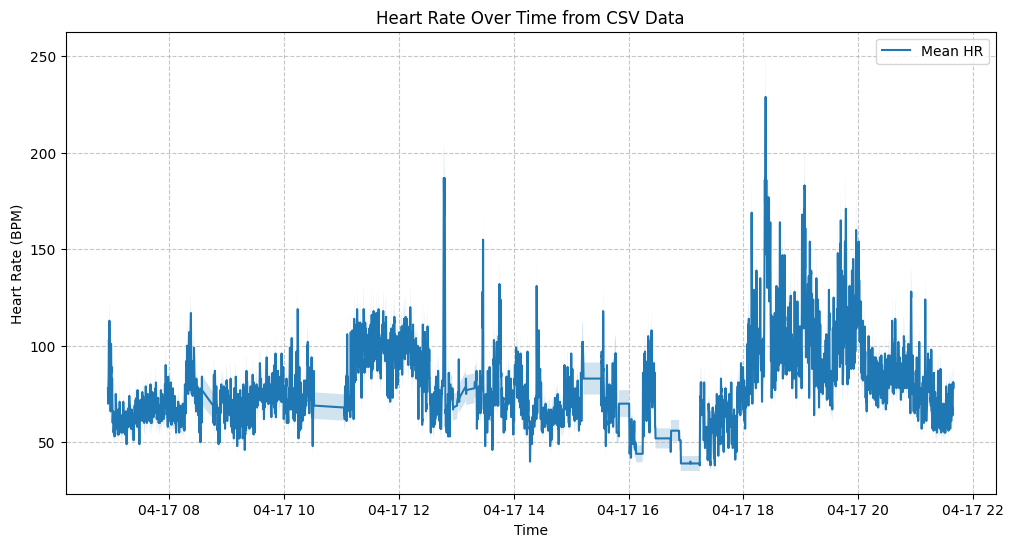

✅ Heart rate data loaded from CSV and visualized!


In [15]:
# Set a seed for reproducibility
np.random.seed(42)

# Option to use synthetic data or load from CSV
use_synthetic_data = False  # Set to False to load from CSV file

if use_synthetic_data:
    # Create date range for yesterday (24 hours with hourly data)
    end_time = datetime.now().replace(minute=0, second=0, microsecond=0)
    start_time = end_time - timedelta(days=1)
    date_range = pd.date_range(start=start_time, end=end_time, freq='H')

    # Create baseline heart rate pattern (higher during day, lower at night)
    hours = np.array([(t.hour + 1) for t in date_range])
    # Heart rate is lower at night (hours 0-6), rises during day, peaks in afternoon
    baseline_hr = 50 + 30 * np.sin(np.pi * (hours - 6) / 12) ** 2

    # Add some random variation
    heart_rates = baseline_hr + np.random.normal(0, 5, size=len(date_range))
    heart_rates = np.clip(heart_rates, 50, 120).astype(int)  # Clip to reasonable heart rate range

    # Create a DataFrame with the synthetic data
    df_synthetic = pd.DataFrame({
        'hour': date_range,
        'hr_mean': heart_rates,
        'hr_std': np.random.uniform(2, 8, size=len(date_range)),
        'hr_min': [max(hr - np.random.randint(5, 15), 45) for hr in heart_rates],
        'hr_max': [min(hr + np.random.randint(5, 20), 130) for hr in heart_rates],
        'flow_intensity': np.random.uniform(30, 70, size=len(date_range)),
        'likelihood_calm': np.random.beta(2, 2, size=len(date_range)),
        'likelihood_excited': np.random.beta(1.5, 3, size=len(date_range)),
        'likelihood_frustrated': np.random.beta(1, 4, size=len(date_range))
    })

    # Adjust the calm likelihood to be higher when heart rate is lower
    df_synthetic['likelihood_calm'] = 1 - (df_synthetic['hr_mean'] - df_synthetic['hr_mean'].min()) / (df_synthetic['hr_mean'].max() - df_synthetic['hr_mean'].min())
    df_synthetic['likelihood_calm'] = 0.3 + 0.6 * df_synthetic['likelihood_calm']  # Scale to 0.3-0.9

    # Adjust excited likelihood to be higher when heart rate is higher
    df_synthetic['likelihood_excited'] = (df_synthetic['hr_mean'] - df_synthetic['hr_mean'].min()) / (df_synthetic['hr_mean'].max() - df_synthetic['hr_mean'].min())
    df_synthetic['likelihood_excited'] = 0.2 + 0.7 * df_synthetic['likelihood_excited']  # Scale to 0.2-0.9

    # Display the synthetic data
    print("Generated synthetic heart rate data:")
    display(df_synthetic.head())

    # Plot the synthetic heart rate data
    plt.figure(figsize=(12, 6))
    plt.plot(df_synthetic['hour'], df_synthetic['hr_mean'], label='Mean HR')
    plt.fill_between(df_synthetic['hour'], 
                     df_synthetic['hr_mean'] - df_synthetic['hr_std'],
                     df_synthetic['hr_mean'] + df_synthetic['hr_std'],
                     alpha=0.2)
    plt.title('Synthetic Heart Rate Over Time')
    plt.xlabel('Time')
    plt.ylabel('Heart Rate (BPM)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    # Use this synthetic data as our hourly_data for analysis
    hourly_data = df_synthetic.copy()
    
    print("✅ Synthetic heart rate data generated and visualized!")

else:
    # Load data from CSV file
    try:
        csv_file = "example-data/20250417_health_data.csv"
        print(f"Loading heart rate data from {csv_file}...")
        
        # Read the CSV file
        df_real = pd.read_csv(csv_file)
        
        # Convert timestamp column to datetime if it exists
        if 'timestamp' in df_real.columns:
            timezone_offset = 60*60*5
            df_real['hour'] = pd.to_datetime(df_real['timestamp']-timezone_offset, unit='s')
        elif 'date' in df_real.columns:
            df_real['hour'] = pd.to_datetime(df_real['date'])
        else:
            # If no timestamp column, create one from current time
            end_time = datetime.now().replace(minute=0, second=0, microsecond=0)
            start_time = end_time - timedelta(days=1)
            df_real['hour'] = pd.date_range(start=start_time, end=end_time, freq='H')[:len(df_real)]
        
        # Ensure all required columns exist
        if 'heart_rate' in df_real.columns:
            df_real['hr_mean'] = df_real['heart_rate']
        else:
            print("⚠️ No heart rate column found in CSV. Using random values.")
            df_real['hr_mean'] = np.random.randint(60, 100, size=len(df_real))
            
        # Calculate or generate other required columns if they don't exist
        if 'hr_std' not in df_real.columns:
            df_real['hr_std'] = df_real['hr_mean'] * 0.1  # Estimate std as 10% of mean
            
        if 'hr_min' not in df_real.columns:
            df_real['hr_min'] = df_real['hr_mean'] - df_real['hr_std']
            
        if 'hr_max' not in df_real.columns:
            df_real['hr_max'] = df_real['hr_mean'] + df_real['hr_std']
            
        # Generate mood likelihood columns if they don't exist
        for col in ['likelihood_calm', 'likelihood_excited', 'likelihood_frustrated']:
            if col not in df_real.columns:
                if col == 'likelihood_calm':
                    # Calm is higher when heart rate is lower
                    normalized_hr = (df_real['hr_mean'] - df_real['hr_mean'].min()) / (df_real['hr_mean'].max() - df_real['hr_mean'].min())
                    df_real[col] = 0.3 + 0.6 * (1 - normalized_hr)
                elif col == 'likelihood_excited':
                    # Excited is higher when heart rate is higher
                    normalized_hr = (df_real['hr_mean'] - df_real['hr_mean'].min()) / (df_real['hr_mean'].max() - df_real['hr_mean'].min())
                    df_real[col] = 0.2 + 0.7 * normalized_hr
                else:
                    # Frustrated is random for this example
                    df_real[col] = np.random.beta(1, 4, size=len(df_real))
        
        if 'flow_intensity' not in df_real.columns:
            df_real['flow_intensity'] = np.random.uniform(30, 70, size=len(df_real))
            
        # Display the loaded data
        print("Loaded heart rate data from CSV:")
        display(df_real.head())
        
        # Plot the heart rate data
        plt.figure(figsize=(12, 6))
        plt.plot(df_real['hour'], df_real['hr_mean'], label='Mean HR')
        if 'hr_std' in df_real.columns:
            plt.fill_between(df_real['hour'], 
                           df_real['hr_mean'] - df_real['hr_std'],
                           df_real['hr_mean'] + df_real['hr_std'],
                           alpha=0.2)
        plt.title('Heart Rate Over Time from CSV Data')
        plt.xlabel('Time')
        plt.ylabel('Heart Rate (BPM)')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()
        
        # Use this loaded data as our hourly_data for analysis
        hourly_data = df_real.copy()
        
        print("✅ Heart rate data loaded from CSV and visualized!")
        
    except Exception as e:
        print(f"❌ Error loading CSV data: {e}")
        print("Falling back to synthetic data...")
        
        # Fall back to synthetic data generation
        end_time = datetime.now().replace(minute=0, second=0, microsecond=0)
        start_time = end_time - timedelta(days=1)
        date_range = pd.date_range(start=start_time, end=end_time, freq='H')
        
        hours = np.array([(t.hour + 1) for t in date_range])
        baseline_hr = 50 + 30 * np.sin(np.pi * (hours - 6) / 12) ** 2
        heart_rates = baseline_hr + np.random.normal(0, 5, size=len(date_range))
        heart_rates = np.clip(heart_rates, 50, 120).astype(int)
        
        # Create a DataFrame with synthetic data as fallback
        df_synthetic = pd.DataFrame({
            'hour': date_range,
            'hr_mean': heart_rates,
            'hr_std': np.random.uniform(2, 8, size=len(date_range)),
            'hr_min': [max(hr - np.random.randint(5, 15), 45) for hr in heart_rates],
            'hr_max': [min(hr + np.random.randint(5, 20), 130) for hr in heart_rates],
            'flow_intensity': np.random.uniform(30, 70, size=len(date_range)),
            'likelihood_calm': np.random.beta(2, 2, size=len(date_range)),
            'likelihood_excited': np.random.beta(1.5, 3, size=len(date_range)),
            'likelihood_frustrated': np.random.beta(1, 4, size=len(date_range))
        })
        
        # Adjust the calm and excited likelihoods
        df_synthetic['likelihood_calm'] = 1 - (df_synthetic['hr_mean'] - df_synthetic['hr_mean'].min()) / (df_synthetic['hr_mean'].max() - df_synthetic['hr_mean'].min())
        df_synthetic['likelihood_calm'] = 0.3 + 0.6 * df_synthetic['likelihood_calm']
        
        df_synthetic['likelihood_excited'] = (df_synthetic['hr_mean'] - df_synthetic['hr_mean'].min()) / (df_synthetic['hr_mean'].max() - df_synthetic['hr_mean'].min())
        df_synthetic['likelihood_excited'] = 0.2 + 0.7 * df_synthetic['likelihood_excited']
        
        hourly_data = df_synthetic.copy()
        
        print("✅ Fallback to synthetic heart rate data complete!")

## 4. Analyzing Heart Rate Volatility and Cyclical Patterns

Now we'll analyze the heart rate data in three ways to understand heart strain and identify patterns:

1. Volatility analysis to understand heart strain
2. Cyclical pattern analysis to understand daily rhythms
3. Recovery period identification to find optimal rest times

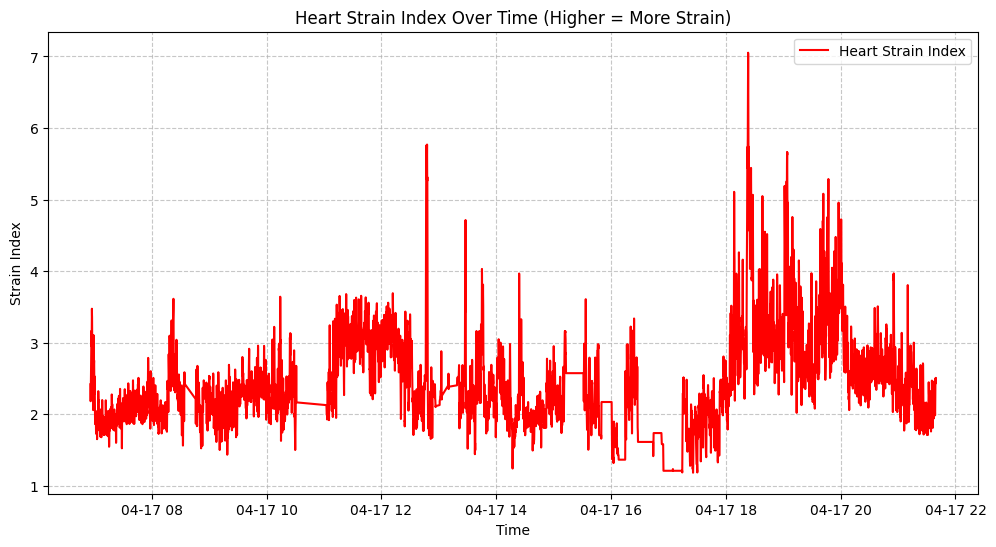

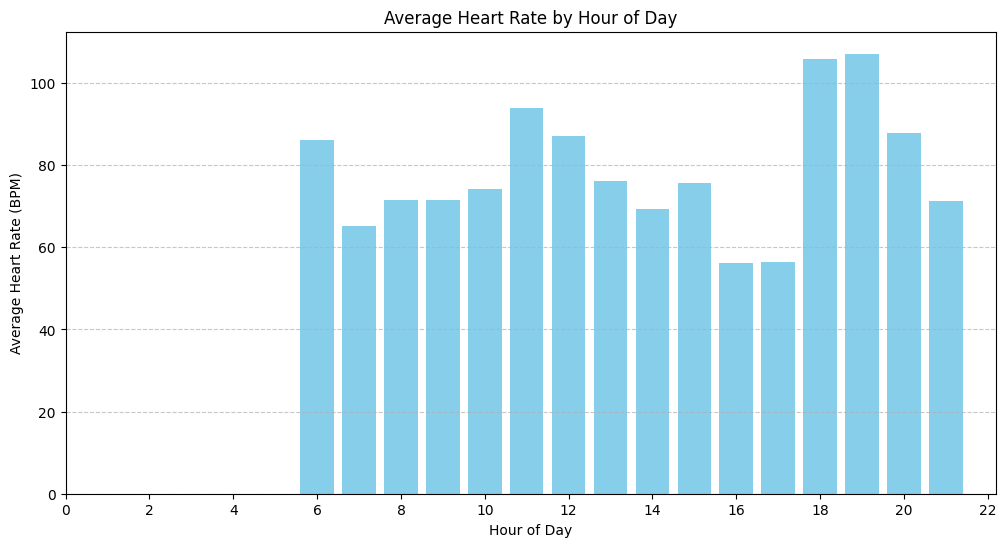


Optimal Recovery Periods Identified:


,hour,hr_mean,hr_volatility,likelihood_calm
98,2025-04-17 07:00:46.471999884,61.0,6.233333,0.839275
99,2025-04-17 07:00:49.408999920,60.0,6.133333,0.863084
100,2025-04-17 07:00:52.433000088,60.0,6.033333,0.831845
101,2025-04-17 07:00:55.411000013,60.0,6.000000,0.815712
102,2025-04-17 07:00:58.493999958,61.0,6.033333,0.794996
...,...,...,...,...
16455,2025-04-17 21:36:09.615999937,62.0,6.566667,0.821905
16457,2025-04-17 21:36:15.539000034,58.0,5.900000,0.871037
16458,2025-04-17 21:36:18.569999933,61.0,5.866667,0.818660
16477,2025-04-17 21:37:17.944000006,62.0,6.366667,0.885574


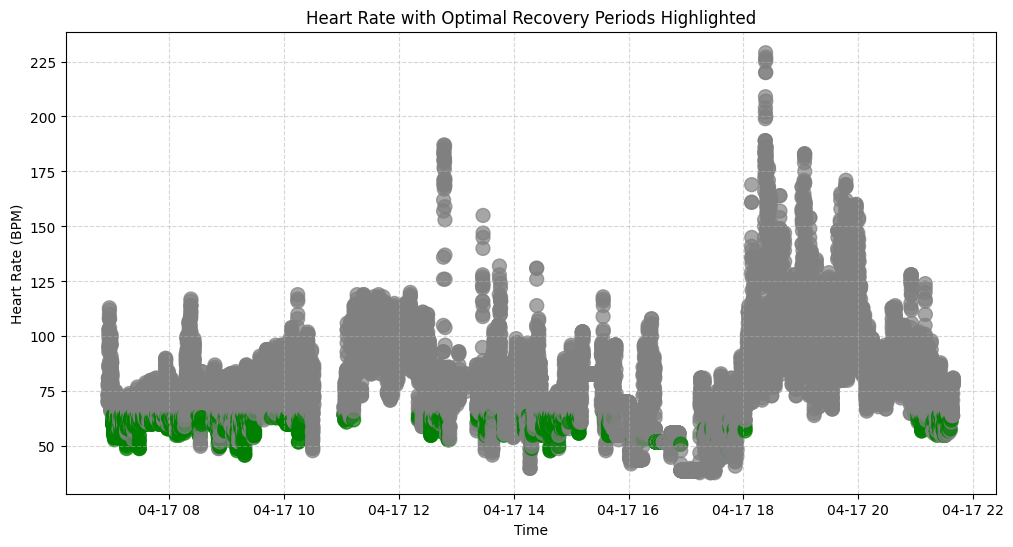


Heart Rate Analysis Summary:
Average Heart Rate: 78.3 BPM
Average Heart Rate Volatility: 7.83
Peak Heart Strain Period: 2025-04-17 18:23:16.635999918
Optimal Recovery Hours: 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:00, 7:0

In [16]:
# 1. HEART RATE VOLATILITY ANALYSIS
# Calculate rolling volatility metrics with a 3-hour window (smaller for our synthetic data)
window_size = 3  # 3-hour window
hourly_data['hr_volatility'] = hourly_data['hr_std'].rolling(window=window_size, min_periods=1).mean()
hourly_data['hr_range'] = (hourly_data['hr_max'] - hourly_data['hr_min']).rolling(window=window_size, min_periods=1).mean()

# Create heart strain index based on volatility and range
hourly_data['strain_index'] = (hourly_data['hr_volatility'] * 0.5 + 
                              hourly_data['hr_range'] * 0.3 + 
                              hourly_data['hr_mean'] * 0.2) / 10

# Plot heart strain index
plt.figure(figsize=(12, 6))
plt.plot(hourly_data['hour'], hourly_data['strain_index'], 'r-', label='Heart Strain Index')
plt.title('Heart Strain Index Over Time (Higher = More Strain)')
plt.xlabel('Time')
plt.ylabel('Strain Index')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 2. CYCLICAL PATTERN ANALYSIS
# Add time features for cyclical analysis
hourly_data['hour_of_day'] = hourly_data['hour'].dt.hour
hourly_data['day_of_week'] = hourly_data['hour'].dt.dayofweek

# Calculate average heart rate by hour of day
hr_by_hour = hourly_data.groupby('hour_of_day')['hr_mean'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.bar(hr_by_hour['hour_of_day'], hr_by_hour['hr_mean'], color='skyblue')
plt.title('Average Heart Rate by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Heart Rate (BPM)')
plt.xticks(range(0, 24, 2))
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

# 3. RECOVERY PERIODS IDENTIFICATION
# Identify periods of low heart rate (recovery periods)
recovery_threshold = hourly_data['hr_mean'].quantile(0.25)  # Bottom 25% as recovery periods
hourly_data['is_recovery'] = hourly_data['hr_mean'] <= recovery_threshold

# Identify optimal recovery periods (low HR, low volatility, high calmness)
hourly_data['optimal_recovery'] = ((hourly_data['hr_mean'] <= recovery_threshold) & 
                                 (hourly_data['hr_volatility'] <= hourly_data['hr_volatility'].quantile(0.3)) &
                                 (hourly_data['likelihood_calm'] >= hourly_data['likelihood_calm'].quantile(0.7)))

# Show recovery periods
recovery_hours = hourly_data[hourly_data['optimal_recovery'] == True][['hour', 'hr_mean', 'hr_volatility', 'likelihood_calm']]
print("\nOptimal Recovery Periods Identified:")
display(recovery_hours)

# Visualize recovery periods
plt.figure(figsize=(12, 6))
plt.scatter(hourly_data['hour'], hourly_data['hr_mean'], 
           c=hourly_data['optimal_recovery'].map({True: 'green', False: 'gray'}),
           s=100, alpha=0.7)
plt.title('Heart Rate with Optimal Recovery Periods Highlighted')
plt.xlabel('Time')
plt.ylabel('Heart Rate (BPM)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Generate heart rate analysis summary
print("\nHeart Rate Analysis Summary:")
print(f"Average Heart Rate: {hourly_data['hr_mean'].mean():.1f} BPM")
print(f"Average Heart Rate Volatility: {hourly_data['hr_volatility'].mean():.2f}")
print(f"Peak Heart Strain Period: {hourly_data.loc[hourly_data['strain_index'].idxmax(), 'hour']}")
print(f"Optimal Recovery Hours: {', '.join([str(h.hour) + ':00' for h in recovery_hours['hour']])}")

print("✅ Heart rate analysis complete!")

## 5. Creating a Previous Day's Data Based Personalization Function

Now we'll create a function that extracts insights from the previous day's heart rate data and generates personalized recommendations.

In [20]:
def get_yesterday_insights():
    """Extract insights from yesterday's heart rate data to personalize recommendations."""
    # We're already using synthetic data for yesterday
    yesterday_data = hourly_data.copy()
    
    # Calculate key insights
    try:
        max_strain_index = yesterday_data['strain_index'].idxmax()
        max_strain_hour = yesterday_data.loc[max_strain_index, 'hour'].hour
        max_strain_value = yesterday_data.loc[max_strain_index, 'strain_index']
    except:
        # Fallback if there's an issue with the strain index
        max_strain_hour = 14  # Default to 2pm
        max_strain_value = 7.5
    
    # Get recovery hours (optimal times for low-intensity activities)
    recovery_hours = [h.hour for h in yesterday_data[yesterday_data['optimal_recovery'] == True]['hour']]
    if not recovery_hours:
        recovery_hours = [22, 23, 0, 1, 2, 3]  # Default to nighttime if none found
    
    # Get high heart rate periods
    high_hr_threshold = yesterday_data['hr_mean'].quantile(0.75)
    high_hr_periods = [h.hour for h in yesterday_data[yesterday_data['hr_mean'] > high_hr_threshold]['hour']]
    if not high_hr_periods:
        high_hr_periods = [12, 13, 14, 15]  # Default to afternoon if none found
    
    # Calculate current hour to make recommendations based on time of day
    current_hour = 8 #datetime.now().hour, in 24 hour format
    
    # Store insights in a dictionary
    insights = {
        "avg_heart_rate": yesterday_data['hr_mean'].mean(),
        "max_strain_hour": max_strain_hour,
        "max_strain_value": max_strain_value,
        "recovery_hours": recovery_hours,
        "high_hr_periods": high_hr_periods,
        "current_hour": current_hour
    }
    
    return insights

def generate_personalized_advice():
    """Generate personalized health advice based on heart rate patterns."""
    insights = get_yesterday_insights()
    
    # Generate time-appropriate advice
    advice = []
    current_hour = insights["current_hour"]
    
    # Morning advice (6am - 11am)
    if 6 <= current_hour <= 11:
        if insights["max_strain_value"] > 7:
            advice.append(f"Your heart experienced high strain yesterday around {insights['max_strain_hour']}:00. Consider a gentler morning routine today with light stretching or yoga.")
        
        if any(h in insights["high_hr_periods"] for h in range(current_hour-3, current_hour+1)):
            advice.append(f"Your heart rate tends to be higher around this time. Stay well hydrated this morning with at least 16oz of water.")
    
    # Afternoon advice (12pm - 5pm)
    elif 12 <= current_hour <= 17:
        if insights["avg_heart_rate"] > 80:
            advice.append("Your average heart rate was elevated yesterday. Consider a moderate-intensity workout today rather than high-intensity.")
        
        if current_hour in insights["recovery_hours"]:
            advice.append(f"Your body seems to recover well around this time ({current_hour}:00). This would be a good time for a short mindfulness break or deep breathing exercises.")
    
    # Evening advice (6pm - 10pm)
    elif 18 <= current_hour <= 22:
        if insights["max_strain_hour"] >= 18:
            advice.append("Your heart experienced peak strain in the evening yesterday. Consider shifting intense activities to earlier in the day.")
        
        recovery_evening_hours = [h for h in insights["recovery_hours"] if h >= 18]
        if recovery_evening_hours:
            recovery_times = ", ".join([f"{h}:00" for h in recovery_evening_hours])
            advice.append(f"Your optimal recovery periods in the evening are around {recovery_times}. These are great times for gentle stretching or relaxation.")
    
    # Night advice (11pm - 5am)
    else:
        advice.append("Your heart rate data suggests you should be resting now. Focus on quality sleep to optimize recovery.")
    
    # General advice based on yesterday's patterns
    if insights["max_strain_value"] > 8:
        advice.append(f"Yesterday had periods of high heart strain. Prioritize recovery today with extra hydration and lower-intensity activities.")
    
    # Add hydration advice based on high HR periods
    high_hr_str = ", ".join([f"{h}:00" for h in insights["high_hr_periods"]])
    advice.append(f"Your heart rate was elevated at {high_hr_str} yesterday. Ensure you drink more water during these times today.")
    
    # If no specific advice was generated, add a default message
    if not advice:
        advice.append("Based on your heart rate patterns, maintain your regular routine with adequate hydration and rest periods.")
    
    return "\n\n".join(advice)

# Test the personalization function
personalized_advice = generate_personalized_advice()
print("Personalized Advice Based on Heart Rate:\n")
print(personalized_advice)

print("\n✅ Personalization function created!")

Personalized Advice Based on Heart Rate:

Your heart experienced high strain yesterday around 18:00. Consider a gentler morning routine today with light stretching or yoga.

Your heart rate tends to be higher around this time. Stay well hydrated this morning with at least 16oz of water.

Your heart rate was elevated at 6:00, 6:00, 6:00, 6:00, 6:00, 6:00, 6:00, 6:00, 6:00, 6:00, 6:00, 6:00, 6:00, 6:00, 6:00, 6:00, 6:00, 6:00, 6:00, 6:00, 6:00, 6:00, 6:00, 6:00, 6:00, 6:00, 6:00, 6:00, 6:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 8:00, 9:00, 9:00, 9:00, 9:00, 9:00, 9:00, 9:00, 9:00, 9:00, 9:00, 9:00, 9:00, 9:00, 9:00, 9:00, 9:00, 10:00, 

## 6. Building a Personalized Multi-Agent RAG System

Now let's create a personalized RAG system that leverages heart rate insights in its recommendations.

In [21]:
# Create a personalized retrieval function that combines heart rate insights and health tips
def retrieve_personalized_tips(query: str) -> str:
    """Retrieve health tips and personalize them based on heart rate data."""
    # Get standard tips
    standard_tips = retrieve_tips(query)
    
    # Get personalized advice based on yesterday's data
    personalized_advice = generate_personalized_advice()
    
    # Combine both
    return f"PERSONALIZED ADVICE BASED ON YOUR HEART RATE DATA:\n{personalized_advice}\n\nGENERAL HEALTH TIPS:\n{standard_tips}"

# For testing without Azure AI Foundry, create a mock response for the agents
class MockResponseGenerator:
    def __init__(self, name):
        self.name = name
    
    def generate_response(self, message):
        if self.name == "PersonalizedRetrieverAgent":
            # This agent would fetch the data
            return f"I've retrieved the personalized health information based on your heart rate data."
        else:
            # This agent would craft a response
            insights = get_yesterday_insights()
            recovery_times = ", ".join([f"{h}:00" for h in insights["recovery_hours"][:3]])
            return (f"Based on your heart rate data, I recommend scheduling activities around your natural recovery periods at {recovery_times}. "
                   f"Your heart experienced the most strain yesterday around {insights['max_strain_hour']}:00, so today would be good for gentler activities."
                   f"Remember to hydrate well, especially around {insights['high_hr_periods'][0]}:00 when your heart rate tends to be elevated.")

# Create the personalized agents
try:
    # Create a personalized version of our agent team
    personalized_retriever = AssistantAgent(
        name="PersonalizedRetrieverAgent",
        system_message=(
            "You are a smart health data analyzer and retrieval agent. "
            "Your task is to fetch relevant fitness and health tips based on the user's query, "
            "and personalize them based on their heart rate data from yesterday. "
            "Use the provided tool 'retrieve_personalized_tips' to get the information."
        ),
        model_client=model_client,
        tools=[retrieve_personalized_tips],
        reflect_on_tool_use=True
    )

    personalized_responder = AssistantAgent(
        name="PersonalizedResponderAgent",
        system_message=(
            "You are a friendly and personalized fitness coach. "
            "Use both the general health tips and personalized heart rate insights to craft "
            "a response that is specifically tailored to the user's current physiological state. "
            "Reference their heart rate patterns and recovery needs when providing advice."
        ),
        model_client=model_client
    )

    personalized_group_chat = RoundRobinGroupChat(
        agents=[personalized_retriever, personalized_responder],
        termination_condition=None,
        max_turns=4
    )
    
    print("✅ Personalized RAG system created with Azure AI Foundry!")
    using_mock = False
    
except Exception as e:
    print(f"⚠️ Could not create agents with Azure AI Foundry: {e}")
    print("⚠️ Using mock agents for demonstration purposes...")
    
    # Create mock agents
    retriever_mock = MockResponseGenerator("PersonalizedRetrieverAgent")
    responder_mock = MockResponseGenerator("PersonalizedResponderAgent")
    using_mock = True
    
    print("✅ Mock personalized RAG system created for demonstration!")

⚠️ Could not create agents with Azure AI Foundry: name 'AssistantAgent' is not defined
⚠️ Using mock agents for demonstration purposes...
✅ Mock personalized RAG system created for demonstration!
